In [1]:
using Pkg
Pkg.activate("../..")
using Plots, PhasorNetworks, Random, DifferentialEquations

  Activating project at `~/code/PhasorNetworks.jl`


# Oscillators and Waves

In the previous notebook, we introduced several concepts: encoding information into phase, representation of phase values by waves in time, and computing the similarity between large collections of phase values. Let's now concentrate on one aspect of this: representing phase via waves.

Oscillators are physical, self-driving systems which can generate waveforms. In many ways, biological neurons can be interpreted as oscillators: they utilize chemical sources of energy and - via internal and external currents - go through regular, cyclic changes in cellular potential. This connection was the driving force behind the "resonate-and-fire" (or Izhikevich) neuron, which codifies the behavior of a neuron into a simple, oscillatory system:

$$ \frac{dU}{dt} = (k + i \omega) \cdot U + I(t) $$

Where $U$ is a complex-valued potential (it has both real and imaginary components, corresponding to the neuron's current and voltage, respectively). $\omega$ is the angular frequency of the neuron, and $k$ is the leakage. Let's look at an example of how a resonate-and-fire (R&F) neuron behaves. We'll set up the constants, input current, and differential equation first:

In [2]:
# we'll start by define a leakage value...
# (this is always negative, or the neuron will "explode"
k = -0.2
# ...an angular frequency... 
ω = 2π
# ...and a current function which provides an impulse once each period
I(t) = mod(t, 1.0) < 0.05
# now, we can declare the R&F differential equation we're going to solve!
dzdt(u,p,t) = (k + 1im * ω) * u + I(t)

dzdt (generic function with 1 method)

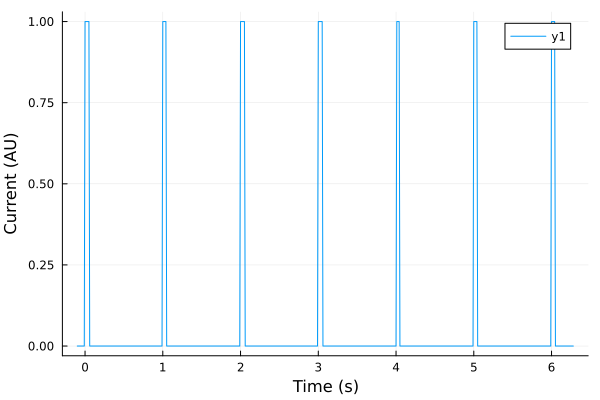

In [3]:
# let's visualize this current function
ts = -0.1:0.01:2π
plot(ts, I.(ts))
xlabel!("Time (s)")
ylabel!("Current (AU)")

And then solve it:

In [4]:
# and the initial potential of the neuron (zero)
u0 = ComplexF32(0.0)
# as well as the time we're going to solve over - 0 to 10 seconds.
tspan = (0.0, 10.0)
# setup the ODE problem
prob = ODEProblem(dzdt, u0, tspan)
# the solver arguments
solver_args = Dict(:dt => 0.01f0,
                    :adaptive => false,
                    :save_start => true)
# and pass it to the differential equation solver
sol = solve(prob, Tsit5(); solver_args...);

Thanks to the amazing Julia package DifferentialEquations, we now have a solution to the R&F neuron which we can visualize:

In [5]:
function plot_solution(sol, tspan::Tuple{Real, Real}, name::String, dt_outer::Real = 0.05, dt_inner::Real=0.01, scale::Real=1.05)
    tbase = tspan[1]:dt_outer:tspan[2]
    sample = sol.(tbase)
    limits_y = scale .* extrema(imag.(sample))

    anim = @animate for t in tbase
        tbase_sample = tspan[1]:dt_inner:t
        sample = sol.(tspan[1]:dt_inner:t)
        plot(tbase_sample, real.(sample), ylim=limits_y, xlim=(tspan[1], tbase[end]), label="Current")
        plot!(tbase_sample, imag.(sample), ylim=limits_y, xlim=(tspan[1], tbase[end]), label="Voltage")
        xlabel!("Time")
        ylabel!("Current, Voltage")
    end
    return gif(anim, name, fps=20)
end

plot_solution (generic function with 4 methods)

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/R&F animation 2.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/R&F animation 2.gif")
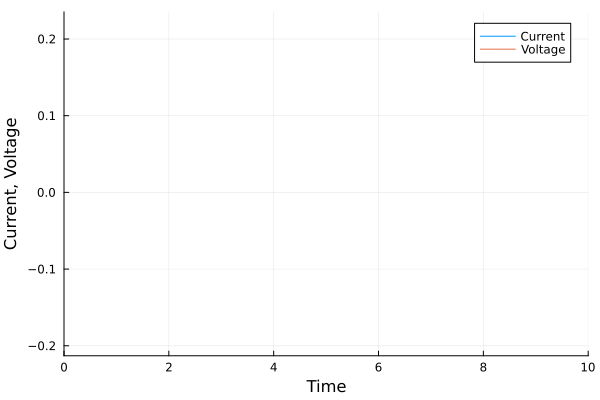

In [6]:
plot_solution(sol, tspan, "R&F animation 2.gif")

As you can see, when you plot the voltage and current against time, we can see that (roughly) sinusoidal waves are produced for each! How is this behavior created from the complex-domain behavior of the R&F neuron?

To those familiar with Euler's identity, the answer should be clear: we're actually drawing out a near-circular path in the complex domain, so trigonometric transforms of this complex potential into the real and complex domains produce sinusoidal waveforms:

In [7]:
function plot_complex_solution(sol::ODESolution, tspan::Tuple{Real, Real}, name::String, dt_outer::Real = 0.05, dt_inner::Real=0.01, scale::Real=1.05)
    tbase = tspan[1]:dt_outer:tspan[2]
    sample = sol.(tbase)
    limits_x = scale .* extrema(real.(sample))
    limits_y = scale .* extrema(imag.(sample))

    anim = @animate for t in tbase
        tbase_sample = tspan[1]:dt_inner:t
        sample = sol.(tspan[1]:dt_inner:t)
        plot(real.(sample), imag.(sample), ylim=limits_y, xlim=limits_x, legend=false)
        xlabel!("Current (Real)")
        ylabel!("Voltage (Imaginary)")
    end
    return gif(anim, name, fps=20)
end

plot_complex_solution (generic function with 4 methods)

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/R&F complex animation.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/R&F complex animation.gif")
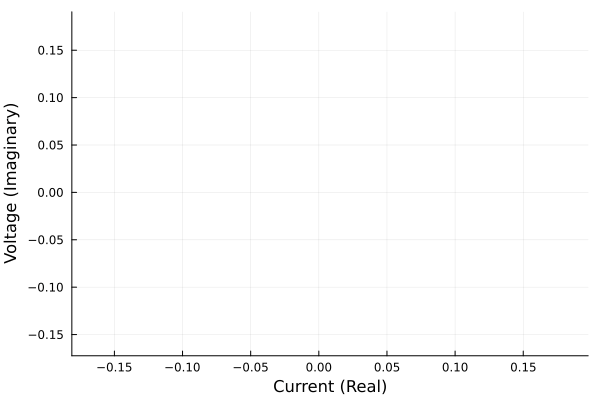

In [8]:
plot_complex_solution(sol, (0.0, 6.0), "R&F complex animation.gif")

So, we can "look" at the behavior of an R&F neuron from different perspective: the voltage and current through time, or a "phase portrait" of the neuron's two-dimensional, complex potential through time. These two perspectives can be used to give different insights into the behavior of an R&F neuron and how we can apply it, so we'll be using both plots in the following material.

# Interference

Let's augment our single R&F neuron with a second one. However, this second neuron will receive current pulses at different times:

In [9]:
function current_with_offsets(t::Real, offsets::AbstractVector{<:Real}, period::Real=1.0, window::Real=0.05)
    relative_time = mod.(t .- offsets, period)
    currents = 1.0 .* (relative_time .< window)
    return currents
end

#we'll also define how to dispatch this function across many values of time
function current_with_offsets(ts::AbstractVector, offsets::AbstractVector{<:Real}, period::Real=1.0, window::Real=0.05)
    currents = stack([current_with_offsets(t, offsets, period, window) for t in ts])
    return currents
end

current_with_offsets (generic function with 6 methods)

We'll keep one current pulse which arrives once every second, and another pulse which arrives 0.4 seconds behind it:

In [10]:
offsets = [0.0, 0.40]

2-element Vector{Float64}:
 0.0
 0.4

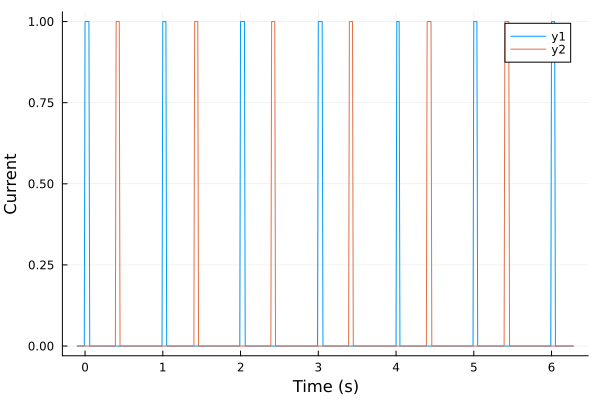

In [11]:
plot(ts, current_with_offsets(ts, offsets)')
xlabel!("Time (s)")
ylabel!("Current")

In [12]:
#define a new current function with these offsets
I2(t) = current_with_offsets(t, offsets)
#and update the differential equation with this new current input
dzdt(u,p,t) = (k + 1im * ω) .* u .+ I2(t)

dzdt (generic function with 1 method)

In [13]:
#setup and solve the differential equation
u0 = zeros(ComplexF32, (2))
prob = ODEProblem(dzdt, u0, tspan)
sol = solve(prob, Tsit5(); solver_args...);

In [14]:
function plot_voltages(sol::ODESolution, tspan::Tuple{Real, Real}, name::String, dt_outer::Real = 0.05, dt_inner::Real=0.01, scale::Real=1.05)
    tbase = tspan[1]:dt_outer:tspan[2]
    sample = sol.(tbase) |> stack
    limits_y = scale .* extrema(imag.(vec(sample)))

    anim = @animate for t in tbase
        tbase_sample = tspan[1]:dt_inner:t
        sample = stack(sol.(tspan[1]:dt_inner:t))
        plot(tbase_sample, imag.(sample)', ylim=limits_y, xlim=(tspan[1], tbase[end]), legend=false)
        xlabel!("Time")
        ylabel!("Voltage")
    end
    return gif(anim, name, fps=20)
end

plot_voltages (generic function with 4 methods)

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/two neurons.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/two neurons.gif")
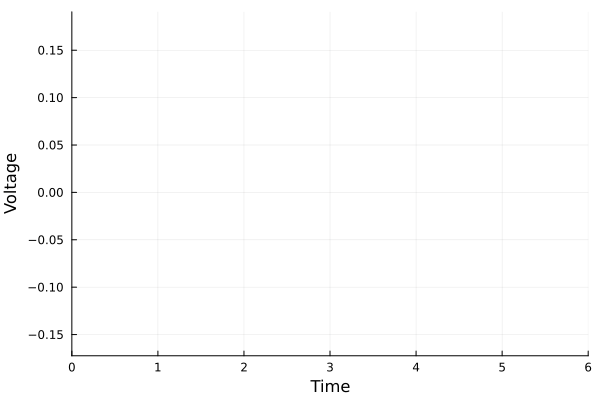

In [15]:
plot_voltages(sol, (0.0, 6.0), "two neurons.gif")

As we can see in the plot above, these waves are out-of-phase due to the relative timing of their inputs. If we add them together, they will destructively interfere:

In [16]:
summed_waves(t) = sol(t)[1] + sol(t)[2]

summed_waves (generic function with 1 method)

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/interference.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/interference.gif")
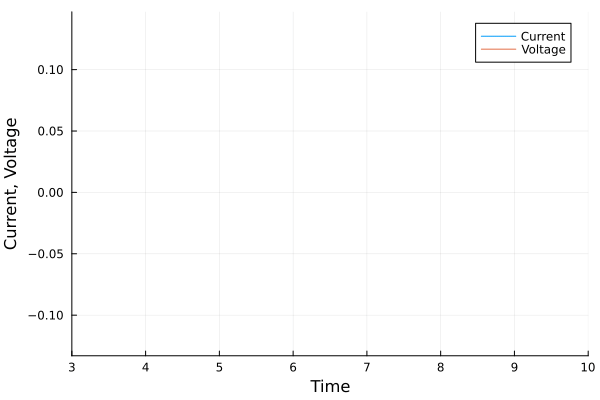

In [17]:
plot_solution(summed_waves, (3.0, 10.0), "interference.gif")

As we can see, the overall amplitude of the summed waves is less than the amplitude of the individual waves!

# Exercises

What is the "period" of the neuron we're simulating? E.g., how long does it take to go from peak to peak? How is this related to the angular frequency?

* The period of the neuron is 1 second. This is directly related to the angular frequency we defined - because the neuron has to sweep out a full $2 \pi$ radians to complete a cycle, an angular frequency of $2 \pi$ rad/s gives it a period of 1.0 seconds!

Given this period, what are the phase values of the waves above? E.g., given an offset of 0.4 seconds from one wave to another, what is the relative *phase value* of this second wave? This is an angular value which you can express in radians or degrees. 

* Given that our neuron sweeps out $2 \pi$ radians per second, multiplying by 0.4 seconds gives us a quantity of $4/5 \pi$ or $144 \degree$ 

How would you adjust the offset of the second wave so that the destructive interference is maximized? In other words, make the waves cancel as much as possible!

* To make the wave destructive, we need to shift forward to a delay of 0.5 seconds - giving us a relative phase of $\pi$ or $180 \degree$.

In [18]:
destructive_offsets = [0.0, 0.5]

2-element Vector{Float64}:
 0.0
 0.5

In [19]:
dzdt(u,p,t) = (k + 1im * ω) .* u .+ current_with_offsets(t, destructive_offsets)
prob = ODEProblem(dzdt, u0, tspan)
sol = solve(prob, Tsit5(); solver_args...);

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_result1.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_result1.gif")
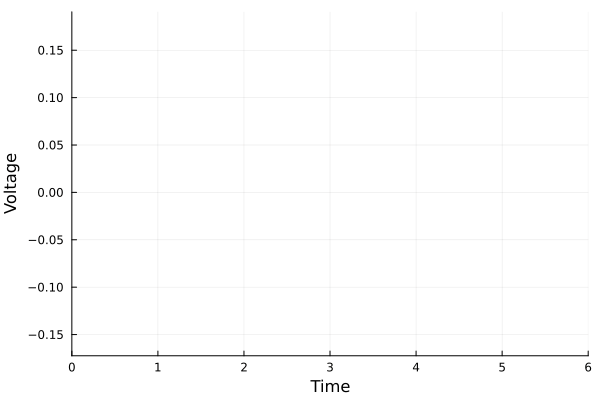

In [20]:
plot_voltages(sol, (0.0, 6.0), "my_result1.gif")

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_interference.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_interference.gif")
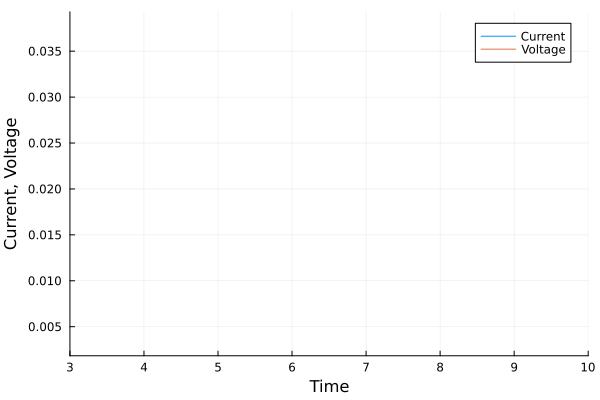

In [21]:
plot_solution(t -> sol(t)[1] + sol(t)[2], (3.0, 10.0), "my_interference.gif")

How can you change the offset so that the waves *constructively* interfere? 

* We can make the waves coincident or delayed at the period of the neuron - either is eqivalent.

In [22]:
constructive_offsets = [0.0, 1.0]

2-element Vector{Float64}:
 0.0
 1.0

In [23]:
dzdt(u,p,t) = (k + 1im * ω) .* u .+ current_with_offsets(t, constructive_offsets)
prob = ODEProblem(dzdt, u0, tspan)
sol = solve(prob, Tsit5(); solver_args...);

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_result1.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_result1.gif")
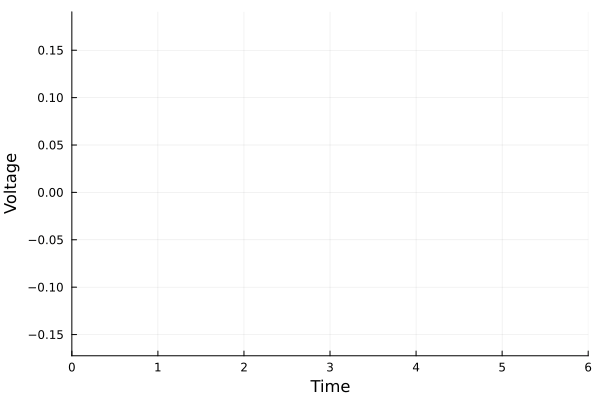

In [24]:
plot_voltages(sol, (0.0, 6.0), "my_result1.gif")

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_interference.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/solutions/my_interference.gif")
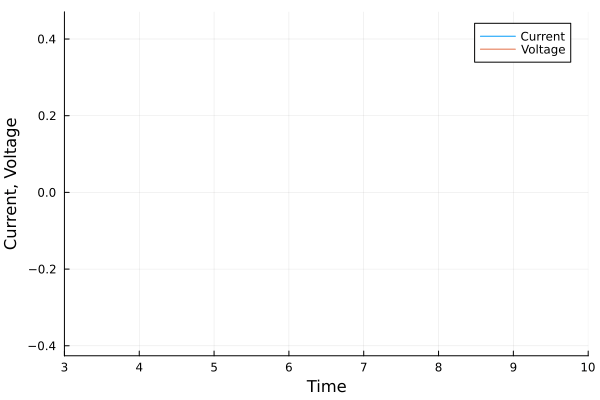

In [25]:
plot_solution(t -> sol(t)[1] + sol(t)[2], (3.0, 10.0), "my_interference.gif")

How does this interference correspond to the concept of similarity which we explored in the previous notebook? What values of similarity correspond to the different types of interference?

* The higher the similarity, the more constructive the interference - and the lower the similarity, the more *de*structive the interference.

Challenge: derive a relationship between the amplitude of the sum of two interfering waves with the similarity defined in the previous notebook. Hint: draw some circles, triangles, and refresh your trig identities!

In the next notebook, we'll demonstrate that this relationship *does* exist, and that wave interference *can* be used to (approximately) calculate the similarity values which we calculated in the last notebook by taking cosine values of angles.